CHAPTER 5 - SUPPORT VECTOR MACHINES

A Support Vector Machine (SVM) is a powerful and versatile ML model, capable of performing linear and non-linear classification, regression and even outlier detection. SVMs are particulary well suited for classification of complex but small - or medium sized datasets

In [1]:
import sklearn
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Linear SVM Classification

The fundamental ideabehind SVMs is better explained with a picture. 

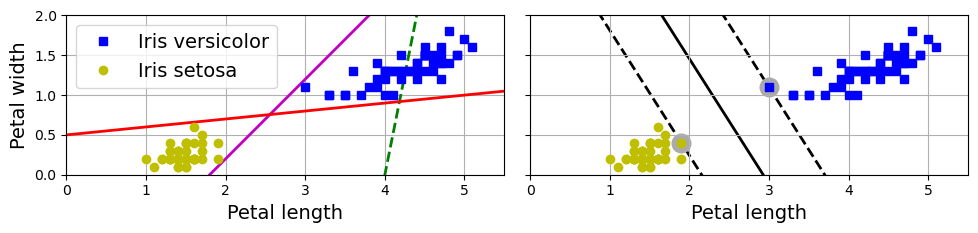

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e100)
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

save_fig("large_margin_classification_plot")
plt.show()

The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separates the classes properly. The other two models work perfectly on this training set, but the decision boundaries come so close on the instances that these models will not perform as well on new instances. In contrast the solid line in the plot on the rigth represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can thing of an SVM classifier as fitting the widest possible street (represented by the parallel dashed line) between the classes. This is called large margin classification.

Notice that addiding more training instances 'off the street' will not affect the decision boundary at all: it is fully determined  (or 'supported') by the instances located on the edge street. These instances are called support vectors.

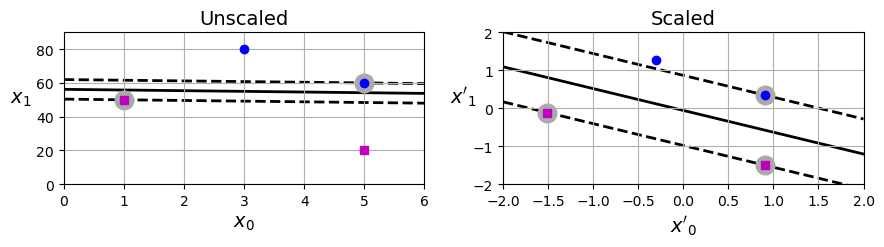

In [4]:
from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

save_fig("sensitivity_to_feature_scales_plot")
plt.show()

SVMs are sensitive to the feature scales, as you can see in the previous image: on the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling the decision boundary looks much better.

Soft Margin Classification

If we strictly impose that all instances be off the street and on the right side, this is called 'hard margin classification'. There are two main issues with hard margin classification. Fist it only works if the data is linearly separable, and second it is quite sensitive to outliers.

To avoid these issues it is preferable to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the 'margin violations' (instances in the middle of the street or even on the wrong side).

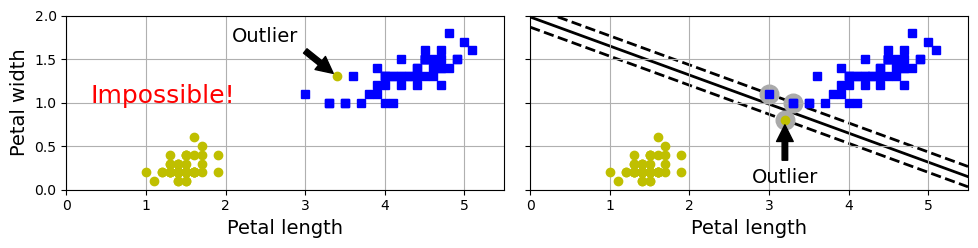

In [5]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

save_fig("sensitivity_to_outliers_plot")
plt.show()

In Sciki-Learn's SVM, you can control this balance using the C hyperparameter: a smaller value of C leads to a wider control street but more margin violations

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 2)  # iris virginica

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, dual=True, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, dual=True, random_state=42))])

In [7]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

In [8]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

Next figure shows the decision boundaries and margins of two sof marjin SVM classifiers on a nonlinearly separabel dataset. On the left, using a low C value the margin is quite large, but many instances end up on the steet. On the right, using a high C value the classifier makes fewer margin violations but ends up with a smaller margin. However, it seems likely that the first classifier will generalize better: in fact even on this training set it makes fewer prediction errors, since most of the margin violations are actually on the correct side of the decision boundary.

In case our SVM model is overfitting, we can try to regularize it by reducing C.

C:\Users\migig\AppData\Local\Temp\ipykernel_9072\2330083529.py:26: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
C:\Users\migig\AppData\Local\Temp\ipykernel_9072\2330083529.py:27: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()


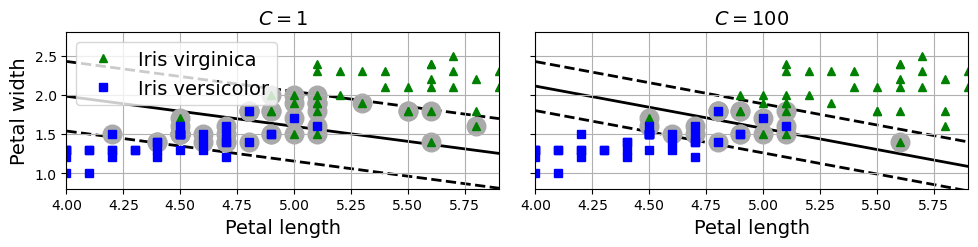

In [9]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)
# dual=True: Solves the dual optimization problem (better for high-dimensional data).
# max_iter=10_000: Ensures convergence (adjust if you see convergence warnings).

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters: To plot the decision boundary in the original (unscaled) feature space.
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find Support vectors (Linear SVC does not do this automatically)

t = y * 2 - 1  # t = y * 2 - 1 is a fixed label conversion for SVMs, independent of feature count.
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^', label='Iris virginica')
# X[:, 0][y==1]: Selects the first feature (petal length) for samples where y == 1.
# X[:, 1][y==1]: Selects the second feature (petal width) for the same samples.
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs', label='Iris versicolor')
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='upper left')
plt.title(f'$C = {svm_clf1.C}$')
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs')
plot_svc_decision_boundary(svm_clf2, 4, 5.9)
plt.xlabel('Petal length')
plt.title(f'$C = {svm_clf2.C}$')
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig('regularization_plot')
plt.show()

Unlikely Logistic Regression Classifiers, svm classifiers do not output probabilities for each class.

The LinearSVC class regularizes the bias ter,, so you should center the training dataset first by substracting its mean. This is automatic if tou cale the data using the StandardScaler. Moreover, make sure you set the loss hyperparameter to'hinge', as it is not the default value. Finally, for beter performance you should set the dual hyperparameter to Fasle, unless there are more features than training instances.

Nonlinear SVM Classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to ve linearly separable. One approach to handly non linear datasets is to add more features, such as polynomial features; in some cases this can result in a linearly separable dataset.

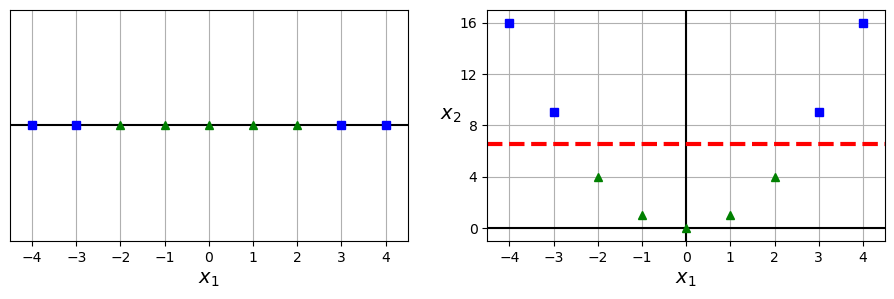

In [10]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)  # 9 points linearly spaced between -4 and 4 (1D feature).
X2D = np.c_[X1D, X1D**2]  # Adds a second feature x1^2 (squared values).
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])  # Labels where class 1 is in the middle region.

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')  # Horizontal axis line
plt.plot(X1D[:, 0][y==0], np.zeros(4), 'bs')  # 4 points at y=0
plt.plot(X1D[:, 0][y==1], np.zeros(5), 'g^')  # 5 points at y=0
plt.gca().get_yaxis().set_ticks([])  # Hide y-axis ticks
plt.xlabel('$x_1$')
plt.axis([-4.5, 4.5, -0.2, 0.2])  # Fix axis limits

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], 'bs')
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], 'g^')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$  ', rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], 'r--', linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig('higher_dimensions_plot', tight_layout=False)
plt.show()

To implement this idea usingSciki-Learn, you can create a Pipeline containing PolynomialFeatures transformer, followed by a StandardScaler and LinearSVC.

In [11]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual=True, max_iter=10000, random_state=42))])

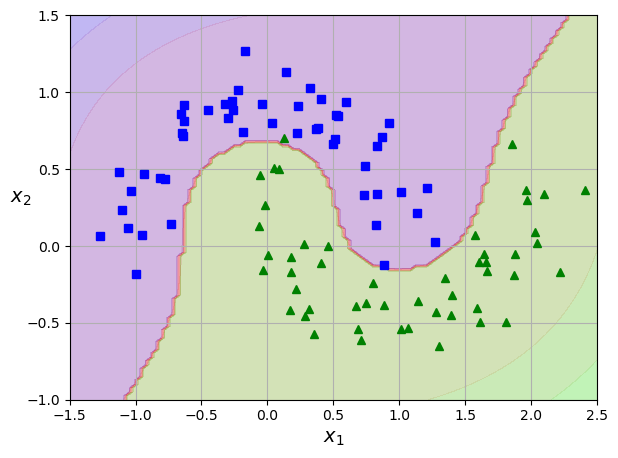

In [12]:
def plot_dataset(X, y, axes): 
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")  # # Class 0: First and second feature for y=0
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")  # First and second feature for y = 1
    plt.axis(axes)  # Set axis limits [xmin, xmax, ymin, ymax]
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)  # Label y-axis (horizontal)

def plot_predictions(clf, axes):
    # Create a grid of 100x100 points covering the axis range
    x0s = np.linspace(axes[0], axes[1], 100)   # x1 values
    x1s = np.linspace(axes[2], axes[3], 100)   # x2 values
    x0, x1 = np.meshgrid(x0s, x1s)    # 2D grid
    X = np.c_[x0.ravel(), x1.ravel()]   # Flatten grid to (10000, 2)

    # Predict class labels and decision function values
    y_pred = clf.predict(X).reshape(x0.shape)   # Predicted classes (0 or 1)
    y_decision = clf.decision_function(X).reshape(x0.shape)   # Distance to boundary

    # Plot decision regions and confidence levels  
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)   # Class areas
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)   # Confidence

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts of ML algorithms (not just SVMs), but a low polynomial degree it cannot deal with very complex datasets, and with a hogh polynomil degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the kernel trick. It makes it possible to get the sam result as if you added many polynomial features, even with very high-degree polynomials, without having to add them. This trick is implemented by the SVC class.

In [13]:
from sklearn.svm import SVC
poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel='poly', degree=3, coef0=1, C=5))

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

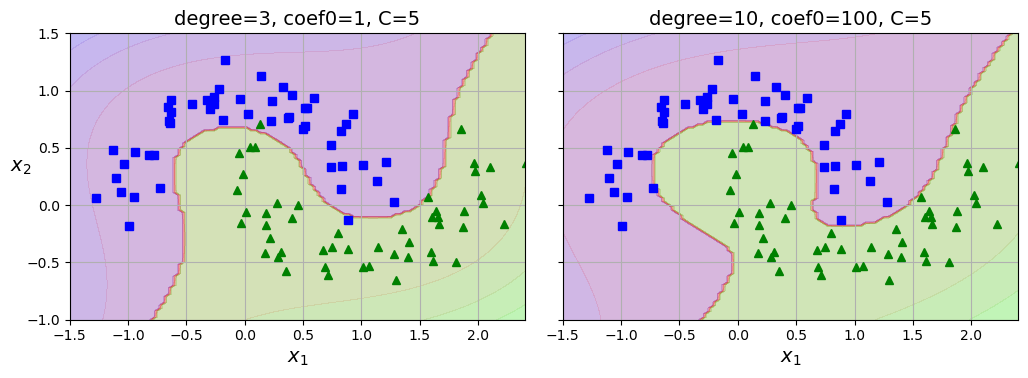

In [14]:
poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='poly', degree=10, coef0=100, C=5)
)
# degree: Higher values create more complex boundaries (risk of overfitting).
# coef0: Controls bias toward high-degree terms (larger = more curved boundaries).
# C: Balances margin width vs. classification errors.
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title('degree=3, coef0=1, C=5')
# Left (degree=3): Smoother boundary, may underfit.

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title('degree=10, coef0=100, C=5')
plt.ylabel('')
# Right (degree=10): Complex boundary, may overfit noisy data.

save_fig('moons_kernelized_polynomial_svc_plot')
plt.show()

On the left side a third-degree polynomial kernel, on the right side a tenth degree polynomial kernel. Obviously if the model is overfitting, you might want to reduce the polynomial degree. Conversely, if its underfitting, you can try increasing it. The hyperparameter 'coef0' controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

A common approach to find the right hyperparameter values is to use grid search. It is often faster to first do a very coarse grid search, then finner grid around the best values found. Having a good sense of what hyperparameter actually does can also help you in the right part of the hyperparameter space.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
from sklearn.model_selection import GridSearchCV

svc_pipeline = make_pipeline(
    StandardScaler(),
    SVC()
)

param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization
    'svc__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'svc__degree': [2, 3, 4]  # Polynomial degree
}

grid_search = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='accuracy',    # Metric to optimize
    verbose=1,
    n_jobs=-1              # Use all CPU cores
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\migig\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100], 'svc__degree': [2, 3, 4],
                         'svc__gamma': ['scale', 'auto', 0.1, 1],
                         'svc__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [17]:
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best parameters: {'svc__C': 10, 'svc__degree': 2, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Best CV score: 0.9733333333333334


In [18]:
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

Test accuracy: 1.0


SIMILARITY FEATURES

Another technique to tackle non linear problems is to add features computed using a similarity function, which measures how much each instance resembles a particular landmark. Let's take the 1D dataset discussed earlier and add two landmarks to it ar x1 = -2 and x1 = 1. nEXT, let's define the similarity function to be the Gausian Radial Basis Function (RBF) with gamma = 0.3.

This is a bell shaped function varying from 0 (very far away from the landmark) to 1 (on the landmark). Now we are ready to compute the new features. For example, let's look at the instance x1=-1: it is located at a distance of 1 from the first landmark and 2 from the second landmark. Therefore its new features are x2 = exp(-0.3 x 1^2) ≈ 0.74 and x3 = exp(-0.3 x 2^2) ≈ 0.30. The following plot shows the transformed dataset (droping the original features). AS you can see, it is now linearly separable.

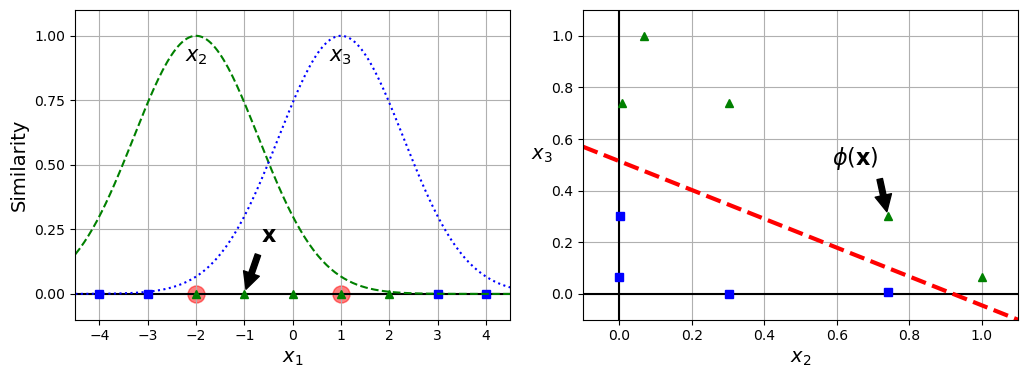

In [19]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1,1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c='red')
plt.plot(X1D[:, 0][yk==0], np.zeros(4), 'bs')
plt.plot(X1D[:, 0][yk==1], np.zeros(5), 'g^')
plt.plot(x1s, x2s, 'g--')
plt.plot(x1s, x3s, 'b:')
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel('$x_1$')
plt.ylabel('Similarity')
plt.annotate(
    r'$\mathbf{x}$',
    xy = (X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha='center',
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)

plt.text(-2, 0.9, '$x_2$', ha='center', fontsize=15)
plt.text(1, 0.9, "$x_3$", ha='center', fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], 'bs')
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], 'g^')
plt.xlabel('$x_2$')
plt.ylabel('$x_3$  ', rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3,0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha = 'center',
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], 'r--', linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])

plt.subplots_adjust(right=1)

save_fig('kernel_method_plot')
plt.show()

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

GAUSSIAN RBF KERNEL

Just like the polynomial features model, the similarity features method can be useful with any Machine Learning algorithm, but it may be computationally expensive to compute to all the additional features, especially on large training sets. Once again the kernel trick does its SVM magic, making it possible to obtain a similar resilt as if you had added many similarity features. LEt`s try the SVC class with the Gaussian RBF kernel:

In [20]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

The model is represented at the bottom-left. The other plots show models trained with different values of hyperparameters gamma and C. Increasing gamma makes the bell-shaped curve narrower. As a result, each instance's range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma values makes the bell-shaped curve wider: instances have a large range of inflience and the decision boundary ends up smother. So gamma acts like a regularization hyperparameter: if your model is overfitting you should reduce it; if it`s underfitting, you should increase it (similar to C hyperparameter).

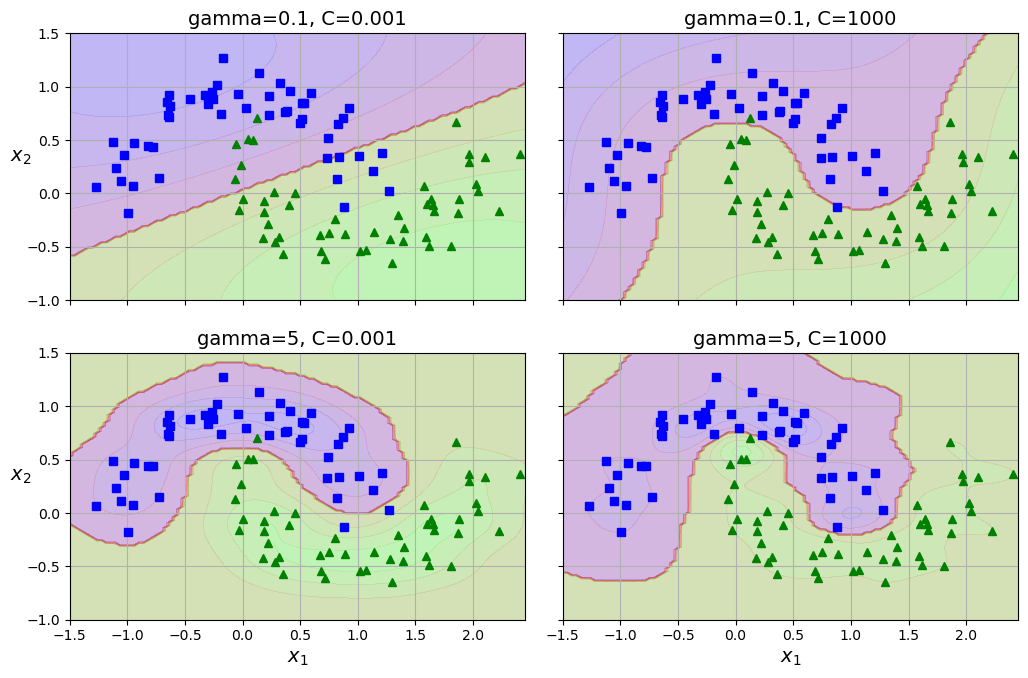

In [21]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

Other kernels exist but are much more rarely. Some kernels are specialized for specific data structures. As a rule of thumb you should always try the linear kernel first (remember that LinearSVC is much faster than SVC(kernel='linear')), especially if the training set is very large or if it has pleny of features. If the training set is not too large, you should also try the Gaussian RBF kernel; it works well in most cases.

COMPUTATIONAL COMPLEXITY

The LinearSVC class is based on the liblinear libray, which implements and optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features. It's training time complexity is roughly O(m x n).

The algorithm takes longer if you require very high precision. This is controlled by the tolerances hyperparameter € (called tol). In most classifications tasks, the default tolerance is fine.

The SVC class is based on the libscm library, which implements an algorithm that supports the kernel trick. The training time complexity us ysyally between O(m^2 x n) and O(m^3 x n). Unfortunately, this means that it gets ddreadfully slow when the number of training instances gets very large (100.000). This algorithm is perfect for small or medium-sized training sets. It scales well with the number of features, especially with sparse features (when each instance has few nonzero fetures). In this case the algorithm scales roughly with the average number of nonzero features per instance.

SVM REGRESSION

To use SVMs for regression instead of classification, the trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limitating the margin violations, SVM Regression tries to fit as many instances as possibleon the street while limiting the margin violations (instances off the street). The width if the street is controlled by a hyperparameter, €.

Next figure shows two linear Regression models trained on some random linear data, one with a large margin (€ = 1.5) and the other wih a small margin (€ = 0.5).

In [22]:
from sklearn.svm import LinearSVR
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, dual=True, random_state=42))

svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, epsilon=0.5, random_state=42))])

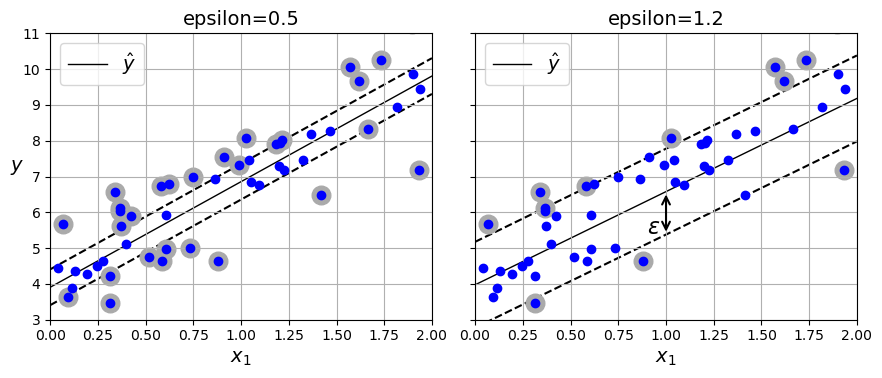

In [ ]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon  # Extract epsilon (ε) from the SVM model's last step
    off_margin = np.abs(y - y_pred) >= epsilon  # Checks which points violate the margin
    return np.argwhere(off_margin)  # Returns the indices of these points

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, 'k-', linewidth = 1, label = r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon,"k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder = -2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180, facecolors='#AAA', zorder=-1)
    plt.plot(X, y, 'bo')
    plt.xlabel('$x_1$')
    plt.legend(loc='upper left')
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(), LinearSVR(epsilon=1.2, dual=True, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f'epsilon={svm_reg[-1].epsilon}')
plt.ylabel('$y$', rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f'epsilon={svm_reg2[-1].epsilon}')
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
        )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
save_fig('svm_regression_plot')
plt.show()

Adding more taining instances within the margin does not affect the models's predictions; thus, the model is said to be €-insensitive.

To tackle nonlinear regression tasks, you can use a kernelized SVM model. The next figure shows a SVM regression on a random quadratic training set, using a second-degree polynomial kernel. There is litle regularization in the left plot (a large value of C), and much more regularization in the rigth plot (small value of C)

In [27]:
from sklearn.svm import SVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(), 
                             SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1))

svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

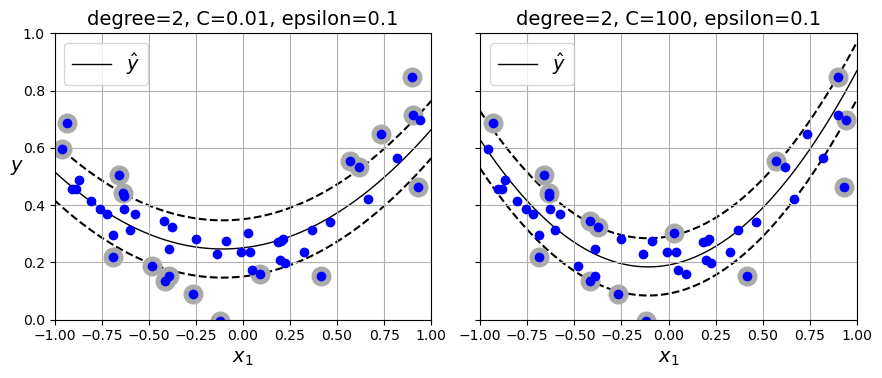

In [ ]:
svm_poly_reg2 = make_pipeline(StandardScaler(),  # Normalizes features (critical for SVM performance).
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)  #Stores their indices in ._support for visualization.
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])   # Set current axis to left subplot.
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])   # Plot regression line, ε-tube, and support vectors.
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The Linear SVR class scales linearly with the size of the training set (just like the LinearSVC class) while the SVR class gets much too slow when the training set grows large (just like SVC class)

EXERCISES

EXERCISE 1 - Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [32]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target

setosa_or_versicolor = (y==0) | (y==1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Now let's build and train 3 models:

1 - Remember that LinearSVC uses loss='squared_hinge' by default, so if we want all 3 models to produce similar results, we need to set loss='hinge'.

2 - Also, the SVC class used an RBF kernel by default, so we need to set kernel='linear' to get similar results as the other two models.

3 - Lastly, the SDGClassifier class does not hae a C hyperparameter, but it has another regularization parameter called apha, so we can tweak it to get similar results as the other two models.

In [34]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss='hinge', C=C, dual=True, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel='linear', C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

Let`s plot the decision boundaries of these three models:

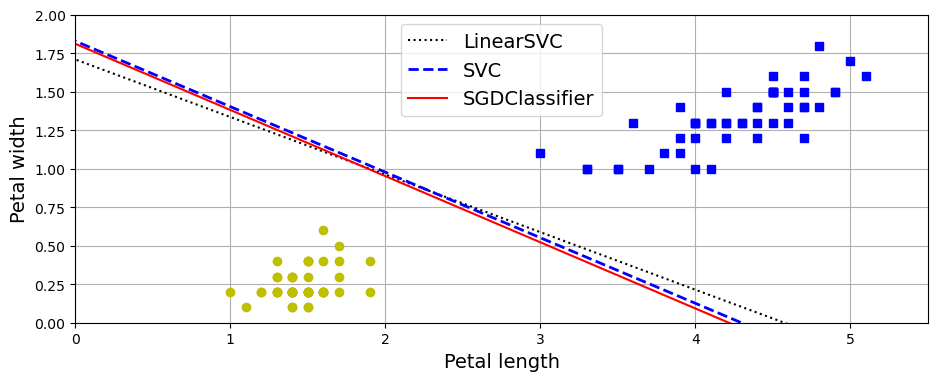

In [35]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], 'k:', label='LinearSVC')
plt.plot(svc_line[:, 0], svc_line[:, 1], 'b--', linewidth=2, label='SVC')
plt.plot(sgd_line[:, 0], sgd_line[:, 1], 'r-', label='SGDClassifier')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='upper center')
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

EXERCISE 10 - Train an SVM classifier on the Wine dataset, which you can load using sklearn.datasets.load_wine(). This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?

In [37]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, random_state=42)
X_train.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [40]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int32

LEt's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest OVR) strategy, so there is nothing special we need to do to handle multiple classes.

In [41]:
lin_clf = LinearSVC(dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=True, random_state=42)

LEt's evaluate this model using cross-validation

In [42]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8575498575498575

85% accuracy on this dataset it is not great. So what happenend? We forgot to scale the features

In [43]:
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(dual=True, random_state=42))

lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=True, random_state=42))])

Let's measure the performance

In [44]:
cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

Nice 97.75%.

Let's see if a kernelized SVM will do better. We will use a default SVC for now.

In [45]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

That`s not better but perhaps we need to do a bit of hyperparameter tunning:

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

params_distrib = {
    'svc__gamma': loguniform(0.001, 0.1),
    'svc__C': uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, params_distrib, n_iter=100, cv=5, random_state=42)

rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901188,
                     random_state=42))])

Ah, this looks excellent! Let's select this model. Now we can test it on the test set:

In [47]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

This tuned kernelized SVM performs better than the LinearSVC model, but we get a lower score on the test set than we measured using cross-validation. This is quite common: since we did so much hyperparameter tuning, we ended up slightly overfitting the cross-validation test sets. It's tempting to tweak the hyperparameters a bit more until we get a better result on the test set, but this would probably not help, as we would just start overfitting the test set. Anyway, this score is not bad at all, so let's stop here.

EXERCISE 11 - Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using sklearn.datasets.fetch_california_housing(). The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?

In [48]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's train a simple LinearSVR

In [49]:
from sklearn.svm import LinearSVR
lin_svr = make_pipeline(StandardScaler(), LinearSVR(dual = True, random_state=42))
lin_svr.fit(X_train, y_train)

c:\Users\migig\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(dual=True, random_state=42))])

It did not converge, so let's increase max_iter:

In [50]:
lin_svr = make_pipeline(StandardScaler(),
                        LinearSVR(max_iter=5000, dual=True, random_state=42))
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, max_iter=5000, random_state=42))])

Let's see how it performs on the training set:

Warning: In recent versions of Scikit-Learn, you must use root_mean_squared_error() to compute the RMSE, instead of mean_squared_error(labels, predictions, squared=False). The following try/except block tries to import root_mean_squared_error, and if it fails it just defines it.

In [51]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

In [52]:
y_pred = lin_svr.predict(X_train)
mse = root_mean_squared_error(y_train, y_pred)
mse

0.979565447829459

Let's look at the RMSE:

In [53]:
np.sqrt(mse)

0.9897299873346563

In this dataset, the targets represent hundreds of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors close to $98,000! Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for C and gamma:

In [54]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

svm_reg = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    "svr__gamma": loguniform(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_reg, param_distrib,
                                   n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F760948260>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F760952240>},
                   random_state=42)

In [55]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485979))])

In [56]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [57]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
rmse

0.5854732265172243

So SVMs worked very well on the Wine dataset, but not so much on the California Housing dataset. In Chapter 2, we found that Random Forests worked better for that dataset.